In [1]:
import aiohttp
import asyncio
import copy
from datetime import datetime
from datetime import date
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_point, geom_jitter, scale_x_datetime, ylab, xlab, ggtitle, xlim, ylim, scale_color_manual, labs, scale_color_discrete, geom_smooth, facet_grid
import plotnine as gg
import time
import urllib3
from strava.data.cache import Cache
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
gg.options.figure_size = (11, 8.5)
pd.set_option('display.max_columns', 500)

## Request the Data
- This is using the previously gathered refresh token and getting an access token
- The refresh token was retrieved using the dumb method of having to go online and all that
- client_id and client_secret were taken from Strava website
- This will not start itself up, it requires an initial setup of creating the "strava_tokens.txt" file with a previous response and valid refresh token

In [2]:
auth_url = "https://www.strava.com/oauth/token"
activities_url = "https://www.strava.com/api/v3/athlete/activities"
stream_url = "https://www.strava.com/api/v3/activities/"
stred = "#F83A07"

In [3]:
def is_access_valid(expiry: int) -> bool:
    return time.time() + 100 < expiry

def get_access_token() -> str:
    """ Read json file storing most recent information, if valid then return, else request new token with refresh token"""
    try:
        with open('strava_tokens.txt') as fh:
            tokens = json.load(fh)
    except:
        quit("Failed to read token file.")
    
    if is_access_valid(tokens["expires_at"]):
        # return the valid access token
        print("Existing access token is valid.")
        return tokens["access_token"]
    else:
        # Request new access and refresh tokens
        print("Requesting new token...")
        # These values are hard-coded as retrieved from Strava
        payload = {
            'client_id': "93786",
            'client_secret': "6054bcb3a50e5fa8769868f4d8273123db037ede",
            'refresh_token': tokens["refresh_token"],
            'grant_type': "refresh_token",
            'f': 'json'
        }

        res = requests.post(auth_url, data=payload, verify=False)
        try:
            with open('strava_tokens.txt', "w") as fh:
                json.dump(res.json(), fh)
            print("Token received.")
        except:
            quit("Failed to write response to file.")

        return res.json()["access_token"]

## Functions to retrieve streams

In [4]:
def request_streams(activ_id: int, streams = "distance,time,altitude,velocity_smooth,heartrate,moving"):
    """ Request streams from Strava api """
    # Set up request parameters
    header = {'Authorization': 'Bearer ' + get_access_token()}
    params = {"keys": streams, "key_by_type": True}
    url = stream_url + str(activ_id) + "/streams"

    # Request the streams
    stream_resp = requests.get(url, params=params, headers=header)
    if stream_resp.status_code != 200:
        print(f"Request failed, status code: {stream_resp.status_code}")
        return None
    
    print(f"Received {len(stream_resp.content)} bytes.")
    return stream_resp.content
    

def get_activity_stream(activities, activ_id: int, cache: Cache, streams = "distance,time,altitude,velocity_smooth,heartrate,moving", ignore_cache=False):
    """ Get the specified activity streams for the activity specified by id """
    
    # Check that the activity id is in the list of activities, else return empty df
    if activ_id not in activities.id.array:
        print("Activity not found, not requesting stream.")
        return None
    
    # Check cache, if not present then request
    if ignore_cache or cache.cache_contains(activ_id=activ_id) is None:
        response = request_streams(activ_id=activ_id, streams=streams)
        if response is None:
            print("Unable to find in cache and unable to retrieve from Strava.  Returning None.")
            return None
        else:
            cache.cache_json(activ_id=activ_id, text=response)
    else:
        print(f"Found activity {activ_id} in cache.")

    
    # Read the file from the cache
    stream_resp = cache.retrieve_stream(activ_id=activ_id)

    return stream_resp


def get_activity_stream_by_date(activities, date: date, cache: Cache, streams = "distance,time,altitude,velocity_smooth,heartrate,moving", index=0):
    """ Get specified activity streams for activity specified by date. If multiple on same day then this will choose the first by default """
    id_of_activity = activities.id.loc[activities.start_date_local.apply(lambda x: x.date()) == date].values[index]
    return get_activity_stream(activities=activities, activ_id=id_of_activity, streams=streams, cache=cache)

def activity_id_by_date(activities, date, index=0):
    return activities.id.loc[activities.start_date_local.apply(lambda x: x.date()) == date].values[index]

## Retrieve all activities
- Loop through pages until all activities received
- Go through until the number received is less than the number requested, indicating all activities sent

In [5]:
def retrieve_activities() -> list:
    """ Retrieve all activities from strava """
    # Loop variables
    num_per_page = 200
    page = 1
    data = list()

    # Header for request
    header = {'Authorization': 'Bearer ' + get_access_token()}

    while True:
        param = {'per_page': num_per_page, 'page': page}
        page_of_data = requests.get(activities_url, headers=header, params=param).json()
        data = data + page_of_data
        print(f"Received page {page} with {len(page_of_data)} activities.")

        if not len(page_of_data):
            print(f"Retrieved {len(data)} activities.")
            return data
        else:
            page += 1

## Function to list all activities in readable format

In [6]:
def list_activities(activities: pd.DataFrame):
    """ Given dataframe of activities, list all activities in some easily readable way """

    # Function to apply to each row of the dataframe given
    def create_summary_string(activities) -> str:
        seconds = activities.moving_time.total_seconds()
        summary_string = f"{activities.start_date_local.date()} - Rode {activities.distance/1000:4.2f}km in {seconds // 3600:02.0f}:{seconds % 3600 // 60:02.0f}:{seconds % 60:02.0f}. ID: {activities.id}."
        return summary_string
    
    print("Summary of Activities:")
    activities.apply(create_summary_string, axis=1).apply(print)

## Simple run

In [7]:
data_raw = retrieve_activities()

Existing access token is valid.
Received page 1 with 200 activities.
Received page 2 with 133 activities.
Received page 3 with 0 activities.
Retrieved 333 activities.


## Create an independent copy so that I don't have to keep requesting the data

In [8]:
data = copy.deepcopy(data_raw)
df = pd.json_normalize(data)

In [25]:
df.columns


Index(['id', 'name', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'elev_high', 'elev_low', 'sport_type',
       'start_date_local', 'timezone', 'start_latlng', 'end_latlng',
       'achievement_count', 'map.id', 'workout_type', 'average_speed',
       'max_speed', 'average_heartrate', 'max_heartrate',
       'map.summary_polyline'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 52 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   resource_state                 333 non-null    int64  
 1   name                           333 non-null    object 
 2   distance                       333 non-null    float64
 3   moving_time                    333 non-null    int64  
 4   elapsed_time                   333 non-null    int64  
 5   total_elevation_gain           333 non-null    float64
 6   type                           333 non-null    object 
 7   sport_type                     333 non-null    object 
 8   workout_type                   314 non-null    float64
 9   id                             333 non-null    int64  
 10  start_date                     333 non-null    object 
 11  start_date_local               333 non-null    object 
 12  timezone                       333 non-null    obj

In [11]:
df.max_heartrate.describe()

count    332.000000
mean     185.481928
std        8.038971
min      116.000000
25%      183.000000
50%      186.000000
75%      189.000000
max      201.000000
Name: max_heartrate, dtype: float64

In [12]:
columns_of_interest = ["id", "name", "distance", "moving_time", "elapsed_time", "total_elevation_gain", "elev_high", "elev_low", 
                        "sport_type", "start_date_local", "timezone", "start_latlng", "end_latlng", "achievement_count", "map.id", 
                        "workout_type", "average_speed", "max_speed", "average_heartrate", "max_heartrate", "map.summary_polyline"]
df = df[columns_of_interest]
df

,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,timezone,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline
0,7928110779,Afternoon Ride,42820.4,5501,5786,267.7,694.2,650.1,Ride,2022-10-07T13:44:16Z,(GMT-07:00) America/Edmonton,"[53.63675703294575, -113.5878349095583]","[53.63683347590268, -113.58797354623675]",2,a7928110779,NaN,7.784,14.578,171.5,192.0,ymjfIthjtTbCfEwBnEqBvHiDhCeEb@{FcBmCPwBdBUtBLh...
1,7916199658,Morning Ride,15448.7,2053,2073,78.0,694.2,652.7,Ride,2022-10-05T10:02:59Z,(GMT-07:00) America/Edmonton,"[53.63657112233341, -113.5879588779062]","[53.63673331215978, -113.58786005526781]",0,a7916199658,NaN,7.525,15.918,165.2,184.0,_njfIphjtTbAzAbAbANZ_AjBg@dBaAxAw@lDSf@sAz@[Ce...
2,7912211536,Afternoon Ride,36290.3,4682,4860,173.7,694.2,652.7,Ride,2022-10-04T13:24:22Z,(GMT-07:00) America/Edmonton,"[53.6368097551167, -113.58770473860204]","[53.63677027635276, -113.5879189800471]",1,a7912211536,NaN,7.751,13.028,163.1,183.0,qnjfIphjtTvB~B`@rAWLkFlO}B|BOq@{@@mC~@qCgAqES_...
3,7902692512,Afternoon Ride,46311.1,6246,6312,447.2,694.2,650.1,Ride,2022-10-02T16:13:19Z,(GMT-07:00) America/Edmonton,"[53.636703891679645, -113.58792048878968]","[53.63675384782255, -113.58781806193292]",2,a7902692512,NaN,7.415,14.872,173.5,190.0,}mjfIthjtThAdBd@dCmCvHcFbHgEpAiJaBwCtAOlF{BtKk...
4,7891643987,Afternoon Ride,41393.2,5271,5426,266.1,694.2,650.1,Ride,2022-09-30T15:33:59Z,(GMT-07:00) America/Edmonton,"[53.6367045622319, -113.58812467195094]","[53.636772790923715, -113.58794982545078]",1,a7891643987,NaN,7.853,14.470,169.3,187.0,_njfIhijtTfBlEu@pAqB`IcDjEmFf@kFqAcCp@wBlBsAhK...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,3425016238,Lunch Ride,17516.8,2891,2891,71.2,693.8,653.7,Ride,2020-04-25T11:48:43Z,(GMT-07:00) America/Edmonton,"[53.636724, -113.587843]","[53.636742, -113.587806]",0,a3425016238,10.0,6.059,13.900,178.0,194.0,knjfIrhjtT`AxAb@v@G|@UvA[pAw@fCy@hBg@t@g@l@u@n...
329,3425017204,Afternoon Ride,14517.0,2848,2848,64.1,693.8,653.7,Ride,2020-04-23T13:02:13Z,(GMT-07:00) America/Edmonton,"[53.636938, -113.587945]","[53.636747, -113.58785]",0,a3425017204,10.0,5.097,10.200,175.4,198.0,qnjfIlhjtTfAvAl@bAEp@OdA]hBc@lBW~@]~@Yj@g@t@_@...
330,3425016478,Afternoon Ride,17605.8,3461,3461,69.9,693.8,653.7,Ride,2020-04-22T14:48:16Z,(GMT-07:00) America/Edmonton,"[53.636929, -113.587659]","[53.636694, -113.587956]",0,a3425016478,10.0,5.087,11.100,176.6,194.0,wmjfIdhjtTx@pAZv@F^?XAb@EZUt@[r@qBpCw@rA_@b@s@...
331,3425016312,Afternoon Ride,7918.8,1333,1333,23.5,694.2,685.7,Ride,2020-04-19T14:07:26Z,(GMT-07:00) America/Edmonton,"[53.63693, -113.588035]","[53.636664, -113.58829]",0,a3425016312,10.0,5.941,11.400,87.0,190.0,aojfIvhjtTx@hAv@tAr@vAp@bBj@dBb@zAZ~AT`BThCJpB...


## Cleaning Some Data
- Formatting dates and times
- Filter out Kayaking
- Filter out erroneously low max speed

In [13]:
df["start_date_local"] = pd.to_datetime(df["start_date_local"], format="%Y-%m-%dT%H:%M:%SZ")
for s in ["moving_time", "elapsed_time"]:
    df[s] = pd.to_timedelta(df[s], unit='S')

df = df[df.sport_type == "Ride"]
df = df.loc[df.max_speed > 0.1]
df = df.loc[df.average_heartrate > 120]

## Various Plots

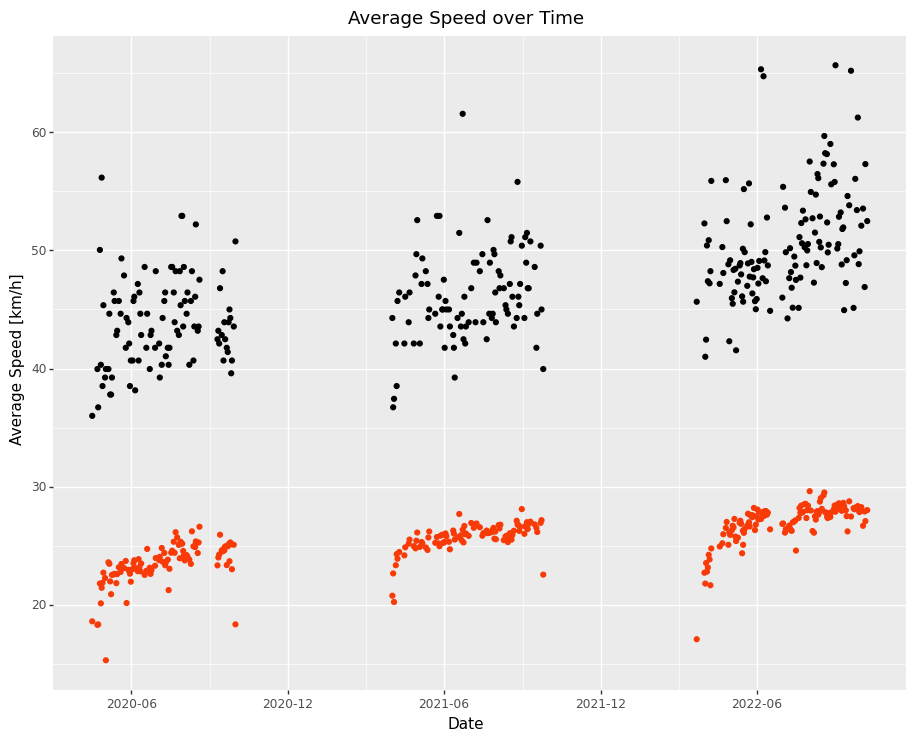

<ggplot: (399404807)>

In [14]:
ggplot(df) \
+ scale_x_datetime(date_breaks="6 months", date_labels="%Y-%m") \
+ xlab("Date") \
+ ylab("Average Speed [km/h]") \
+ ggtitle("Average Speed over Time") \
+ geom_point(aes("start_date_local", "max_speed/0.27777"), color="black") \
+ geom_point(aes("start_date_local", "average_speed/0.27777"), color="#F83A07")

In [15]:
# df['year'] = df['start_date_local'].apply(lambda x: x.year)
df['start_date_local'] = df['start_date_local'].apply(lambda x: x.replace(year=2022))

ggplot(df) \
+ scale_x_datetime(date_breaks="1 months", date_labels="%b") \
+ xlab("Date") \
+ ylab("Average Speed [km/h]") \
+ ggtitle("Average Speed over Time") \
+ geom_point(aes("start_date_local", "max_speed/0.27777"), color="black") \
+ geom_point(aes("start_date_local", "average_speed/0.27777"), color="#F83A07") \
+ geom_smooth(aes(x="start_date_local", y="max_speed/0.27777"), span=0.7, color=stred) \
+ geom_smooth(aes(x="start_date_local", y="average_speed/0.27777"), span=0.7, color="black") \
+ facet_grid('. ~ year')

PlotnineError: 'At least one layer must contain all variables used for facetting'

In [26]:
# lims = [date(2022, 3, 1), date(2022, 10, 1)]
ggplot(df, aes(x="start_date_local")) \
+ scale_x_datetime(date_breaks="1 months", date_labels="%b") \
+ xlab("Date") \
+ ylab("Heartrate [bpm]") \
+ ggtitle("Heartrate over Time") \
+ geom_point(aes(y="average_heartrate"), size=2, color="#F83A07") \
+ geom_point(aes(y="max_heartrate"), size=2, color="black") \
+ facet_grid('. ~ year') \
+ geom_smooth(aes(y="max_heartrate"), span=0.7, color=stred) \
+ geom_smooth(aes(y="average_heartrate"), span=0.7, color="black") \
+ gg.theme(figure_size=(16, 9))

PlotnineError: 'At least one layer must contain all variables used for facetting'

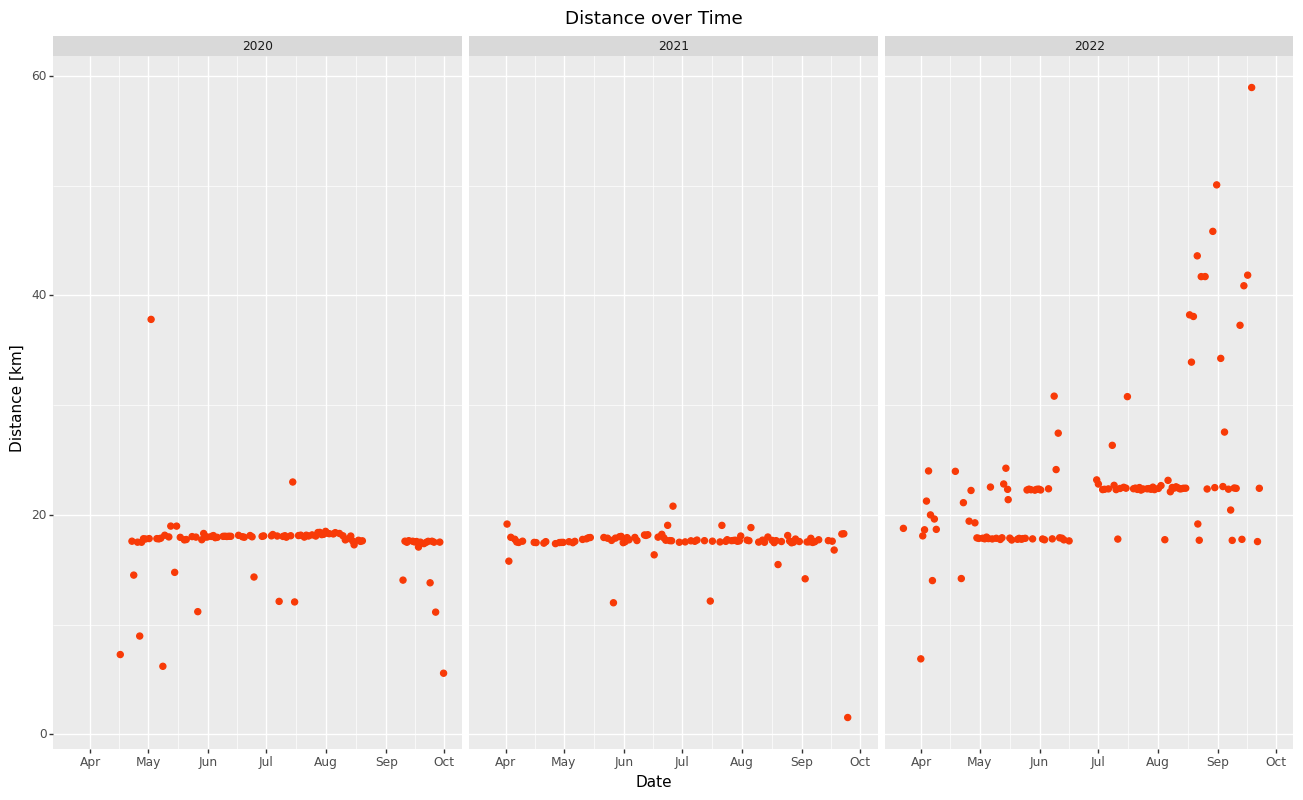

<ggplot: (400210695)>

In [ ]:
lims = [date(2022, 3, 1), date(2022, 10, 1)]
ggplot(df) \
+ scale_x_datetime(date_breaks="1 months", date_labels="%b") \
+ xlab("Date") \
+ ylab("Distance [km]") \
+ ggtitle("Distance over Time") \
+ geom_point(aes("start_date_local", "distance/1000"), size=2, color="#F83A07") \
+ facet_grid('. ~ year') + gg.theme(figure_size=(16, 9))

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


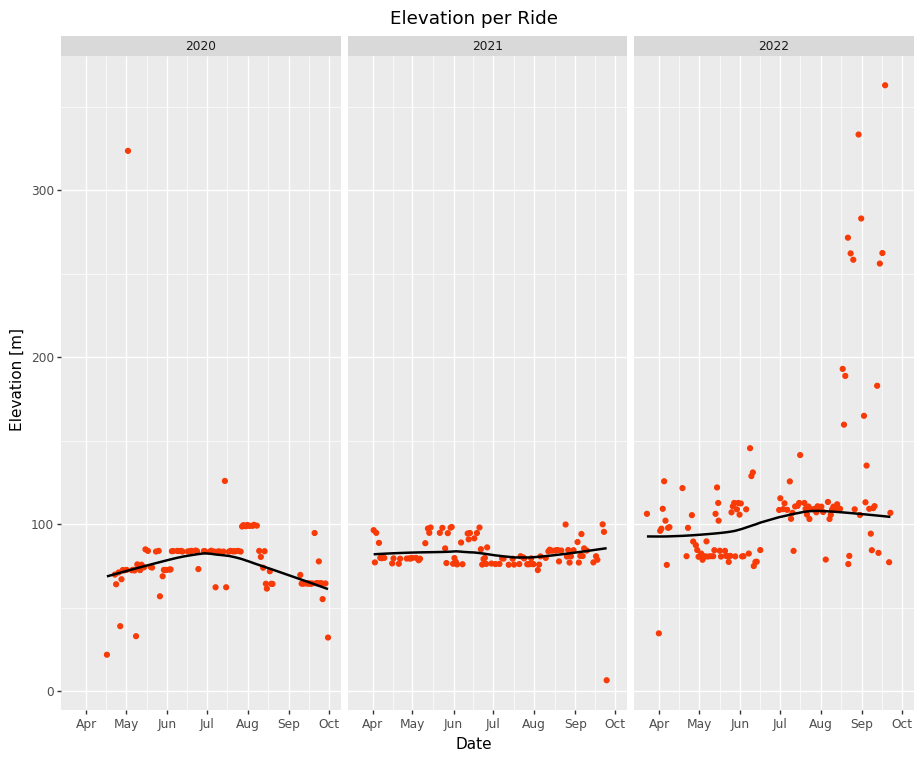

<ggplot: (383163864)>

In [ ]:
ggplot(df) \
+ scale_x_datetime(date_breaks="1 months", date_labels="%b") \
+ xlab("Date") \
+ ylab("Elevation [m]") \
+ ggtitle("Elevation per Ride") \
+ geom_point(aes("start_date_local", "total_elevation_gain"), color="#F83A07") \
+ facet_grid('. ~ year') \
+ geom_smooth(aes(x="start_date_local", y="total_elevation_gain"), span=0.7, color="black")

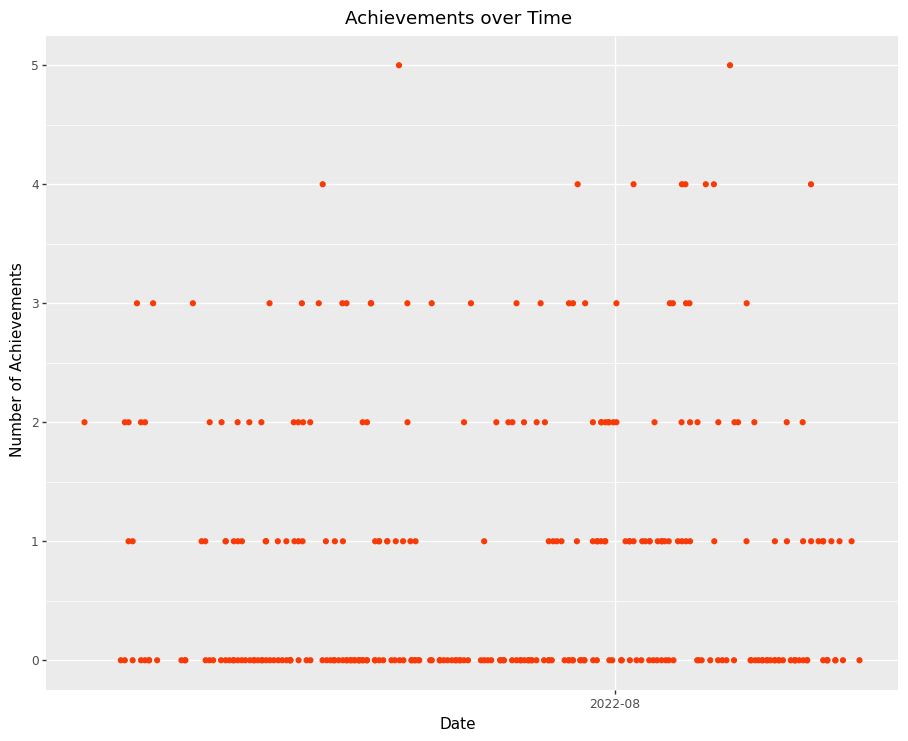

<ggplot: (383093866)>

In [ ]:
ggplot(df) \
+ scale_x_datetime(date_breaks="6 months", date_labels="%Y-%m") \
+ xlab("Date") \
+ ylab("Number of Achievements") \
+ ggtitle("Achievements over Time") \
+ geom_point(aes("start_date_local", "achievement_count"), color="#F83A07")

In [ ]:
ggplot(df, aes(x="start_date_local", y="distance/1000", color="average_speed/0.2777")) \
    + scale_x_datetime(date_breaks="1 months", date_labels="%Y-%m", limits=lims) \
    + geom_point()

NameError: name 'lims' is not defined

In [ ]:
df["year"] = df["start_date_local"].apply(lambda x: x.year)
# df["start_date_local"] = df["start_date_local"].apply(lambda x: x.replace(year=2022))

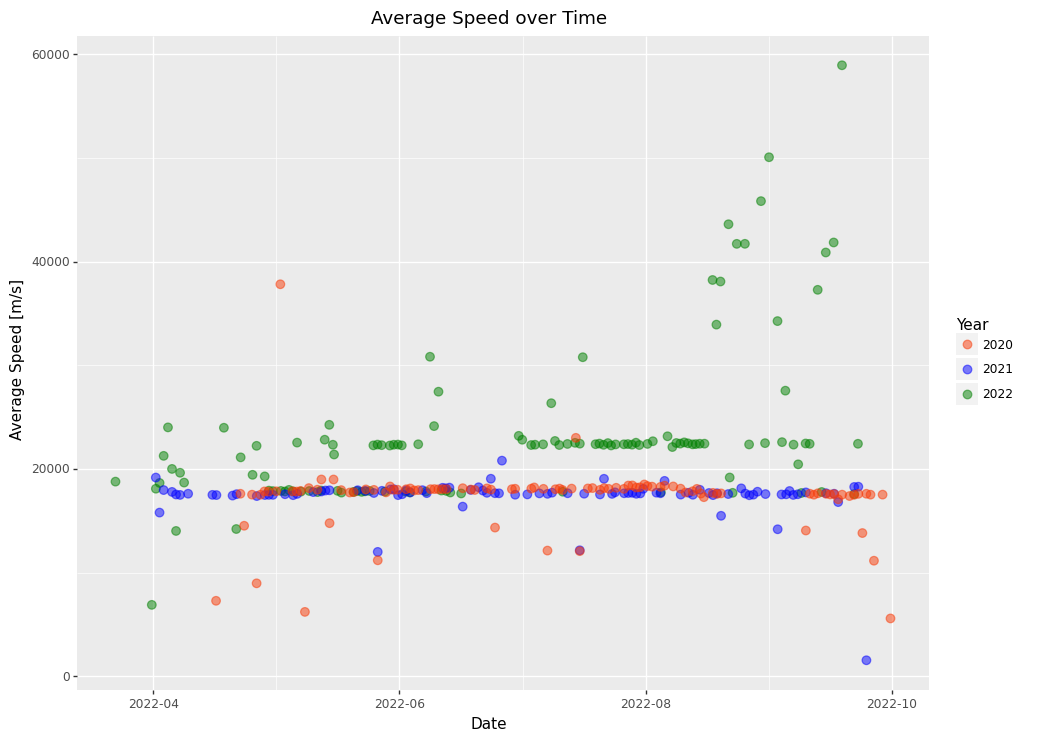

<ggplot: (383308344)>

In [ ]:
ggplot(df) \
+ scale_x_datetime(date_breaks="2 months", date_labels="%Y-%m") \
+ xlab("Date") \
+ ylab("Average Speed [m/s]") \
+ labs(color="Year") \
+ ggtitle("Average Speed over Time") \
+ geom_point(aes(x="start_date_local", y="distance", color="factor(year)"), size=3, alpha = 0.5) \
+ scale_color_manual(values=["#F83A07", "blue", "green"])

In [ ]:
print("Average speed each year:")
df[["average_speed", "start_date_local", "year"]].groupby("year").mean()

Average speed each year:


,average_speed
year,
2020,6.507850
2021,7.147198
2022,7.473711


## Listing Received Activities Summary

In [27]:
list_activities(df)

Summary of Activities:
2022-10-07 - Rode 42.82km in 01:31:41. ID: 7928110779.
2022-10-05 - Rode 15.45km in 00:34:13. ID: 7916199658.
2022-10-04 - Rode 36.29km in 01:18:02. ID: 7912211536.
2022-10-02 - Rode 46.31km in 01:44:06. ID: 7902692512.
2022-09-30 - Rode 41.39km in 01:27:51. ID: 7891643987.
2022-09-28 - Rode 22.32km in 00:48:05. ID: 7881885385.
2022-09-27 - Rode 22.42km in 00:48:04. ID: 7876973997.
2022-09-26 - Rode 27.35km in 00:57:52. ID: 7871826303.
2022-09-25 - Rode 39.40km in 01:24:02. ID: 7867107223.
2022-09-23 - Rode 22.52km in 00:47:51. ID: 7856084651.
2022-09-22 - Rode 22.43km in 00:47:54. ID: 7851318149.
2022-09-21 - Rode 17.57km in 00:37:24. ID: 7846546196.
2022-09-18 - Rode 58.94km in 02:08:42. ID: 7830749817.
2022-09-16 - Rode 41.85km in 01:27:17. ID: 7819087887.
2022-09-14 - Rode 40.88km in 01:33:33. ID: 7809467855.
2022-09-13 - Rode 17.77km in 00:38:46. ID: 7804080763.
2022-09-12 - Rode 37.28km in 01:19:52. ID: 7798391014.
2022-09-10 - Rode 22.42km in 00:47:27. ID:

In [28]:
def create_stream_df(data_str: str, activ_id: int):
    """Create a dataframe from the Strava stream JSON, this includes adding a variable for the activity id."""
    stream_df = pd.DataFrame()
    for k, v in json.loads(data_str).items():
        stream_df[k] = v["data"]
    stream_df["id"] = activ_id
    return stream_df

In [29]:
cache = Cache()
activity_list = ["2022-09-10", "2022-09-09", "2022-09-06", "2022-09-03"]
fancy_activity_list = [x.date().isoformat() for x in df.start_date_local[abs(df.distance/1000 - 22.5) < 0.5]]
# fancy_activity_list = [x.date().isoformat() for x in df.start_date_local[abs(df.moving_time.astype(int) - 2800) < 4000]]
len(fancy_activity_list)

54

In [30]:

# This is a list of four df, each holding a ride
activities = [create_stream_df(get_activity_stream_by_date(df, date.fromisoformat(x), cache), activity_id_by_date(df, date.fromisoformat(x))) for x in fancy_activity_list]
print(activities)

Found activity 7881885385 in cache.
Found activity 7876973997 in cache.
Existing access token is valid.
Received 92105 bytes.
Found activity 7851318149 in cache.
Found activity 7787348827 in cache.
Found activity 7781689276 in cache.
Found activity 7766326850 in cache.
Found activity 7750203808 in cache.
Found activity 7727635082 in cache.
Found activity 7705292874 in cache.
Found activity 7644180962 in cache.
Found activity 7637674534 in cache.
Found activity 7632081532 in cache.
Found activity 7627658857 in cache.
Found activity 7621794737 in cache.
Found activity 7616795019 in cache.
Found activity 7611093486 in cache.
Found activity 7605347569 in cache.
Found activity 7600744550 in cache.
Found activity 7573252801 in cache.
Found activity 7565265218 in cache.
Found activity 7554704447 in cache.
Found activity 7550100612 in cache.
Found activity 7545291549 in cache.
Found activity 7539546230 in cache.
Found activity 7533820817 in cache.
Found activity 7523063837 in cache.
Found acti

In [31]:
# I want to concatenate all of the dfs together
total = pd.concat(activities, axis=0)
total

,moving,velocity_smooth,distance,altitude,heartrate,time,id
0,False,0.000,3.7,692.2,122,0,7881885385
1,True,1.132,6.0,693.6,122,2,7881885385
2,True,1.509,8.2,693.7,122,3,7881885385
3,True,1.697,10.5,693.8,122,4,7881885385
4,True,2.464,16.0,693.9,122,5,7881885385
...,...,...,...,...,...,...,...
2865,True,6.037,22497.0,691.6,174,3531,7469344069
2866,True,8.051,22501.6,691.4,174,3532,7469344069
2867,True,7.844,22506.2,691.3,174,3533,7469344069
2868,True,7.194,22509.9,691.2,174,3534,7469344069


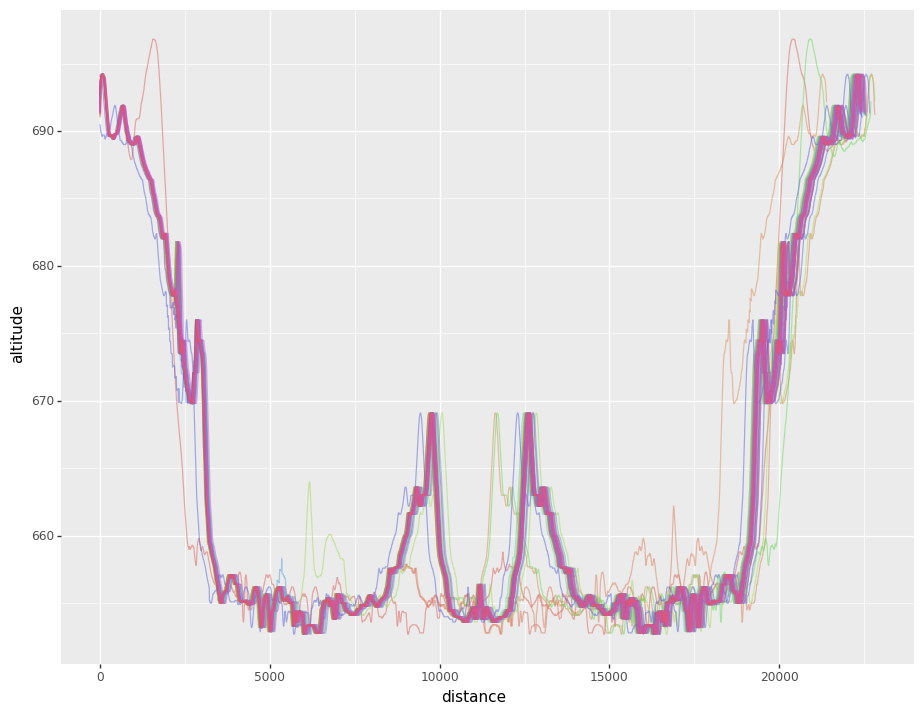

<ggplot: (688573335)>

In [32]:
ggplot(total, aes(x="distance", y='altitude', color="factor(id)")) \
    + geom_line(alpha=0.5) \
    + scale_color_discrete(guide=False)